# Primerjava pristopov za luščenje ključnih besed na anotiranih besedilih iz revije Prispevki za novejšo zgodovino

V tem zvezku predstavljamo primerjavo pristopov za luščenje ključnih besed iz  besedil iz revije Prispevki za novejšo zgodovino, ki imajo označene ključne besede. Ključne besede so označene s strani avtorjev člankov.

Predstavili bomo objektivno primerjavo pristopov za luščenje besed. Primerjali bomo izluščene besede s ključnimi besedami, ki so jih označili avtorji člankov. Za vsako metodo bomo prikazali povprečno preciznost (precision), priklic (recall) in mero F1.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import string
import ast

import nltk
from textsemantics.server_api import ServerAPI
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_SLOVENE
from matplotlib import pyplot as plt
import yake
import rake

from textsemantics import specific_words
from utils.scores import (
    precision, recall, average_precision, average_recall, average_f_score,
    take_n, score_in_len_range
)

Naložimo metapodatke in dokumente iz zbirke CTCH - članki objavljeni v reviji Prispevki za novejšo zgodovino. Dokumente preprocesiramo in izluščimo posamezne besede.

In [4]:
nltk.download('stopwords', quiet=True)
lemmatizer = Lemmatizer(dictionary=DICTIONARY_SLOVENE)

def preprocess(corpus):
    stop_words = set(stopwords.words('slovene'))
    tokenizer = RegexpTokenizer("\w+")
    
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans({punct: " " for punct in string.punctuation}))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]
        # lematizer in rare cases produce empty strings - removing them
        tokens = list(filter(lambda a: a != '', tokens))  
        preprocessed.append(tokens)
        
    return preprocessed

api = ServerAPI()
metadata = api.get_metadata('CTCH')
metadata["texts"] = api.get_texts(urls=metadata['File'])
metadata = metadata[metadata["texts"].apply(lambda x: len(x) > 50)]

# stolpec s ključnimi besedami vsebuje seznam zapisan kot niz - pretovri v seznam
metadata["Keywords"] = metadata["Keywords"].apply(ast.literal_eval)
# pretvorba ključnih besed v posamezne besede in lematizacija
metadata["Keywords_one_word"] = metadata["Keywords"].apply(
    lambda ph: [lemmatizer.lemmatize(w) for p in ph for w in p.split()]
)
# izpusti en članek brez ključnih besed
metadata = metadata[metadata["Keywords_one_word"].str.len() != 0]

full_texts = metadata["Abstract"] + "\n" + metadata["texts"]
tokens_list = preprocess(full_texts)

print(f"Število dokumentov: {len(metadata)}")

84
Število dokumentov: 83


Poglejmo si podatkte in izseke prvih 5 dokumentov

In [5]:
metadata.head()

,Title,Abstract,Keywords,File,URL,texts,Keywords_one_word
0,Hrana na bojiščih prve svetovne vojne: izkušnj...,Prehrana vojakov na bojišču je bila vedno izre...,"[Avstro-Ogrska, 1. svetovna vojna, vojaška izk...",http://file.biolab.si/text-semantics/data/CTCH...,https://ojs.inz.si/pnz/article/view/95/109,1. Raziskovanje vojaških izkušenj\nV zadnjih d...,"[Avstro-Ogrski, 1., svetoven, vojen, vojaški, ..."
1,Ženske v vojni in o véliki vojni,Članek se ukvarja z vplivi prve svetovne vojne...,"[prva svetovna vojna, ženske, zgodovina spola,...",http://file.biolab.si/text-semantics/data/CTCH...,https://ojs.inz.si/pnz/article/view/91/113,V zadnjih dvajsetih letih je prva svetovna voj...,"[prvi, svetoven, vojen, ženski, zgodovina, spo..."
2,»Militarizacija materinstva« – ženski »naravni...,"Prispevek s pomočjo publicistike, zakonodaje, ...","[materinstvo, rodnost, vzgoja, otroci, ženske]",http://file.biolab.si/text-semantics/data/CTCH...,https://ojs.inz.si/pnz/article/view/92/114,1. Uvod1\nV času prve svetovne vojne je v štev...,"[materinstvo, rodnost, vzgoja, otrok, ženski]"
3,Skrb v službi vojne: bolniške strežnice na Kra...,Že pred začetkom prve svetovne vojne je v Avst...,"[bolniške sestre, strežnice, prva svetovna voj...",http://file.biolab.si/text-semantics/data/CTCH...,https://ojs.inz.si/pnz/article/view/84/111,1. Uvod\nNa Slovenskem dojemanje prve svetovne...,"[bolniški, sestra, strežnica, prvi, svetoven, ..."
4,K razumevanju ženskega dela v veliki vojni1,Članek se ukvarja s presekom vojne ekonomije i...,"[prva svetovna vojna, vojno gospodarstvo, žens...",http://file.biolab.si/text-semantics/data/CTCH...,https://ojs.inz.si/pnz/article/view/90/106,1. Uvod\nIzstopajoči delež zgodovinskih razisk...,"[prvi, svetoven, vojen, vojen, gospodarstvo, ž..."


Sedaj bomo pridobili ključne besede z vsako od primerjanih metod:
- [TF-IDF](https://github.com/biolab/text-semantics/blob/main/examples/04_03_specific_words_with_tfidf.ipynb)
- [Metodi z vložitvami:](https://github.com/biolab/text-semantics/blob/main/examples/04_01_specific_words_with_embeddings.ipynb) 1) upoštevajoč vse besede v korpusu, 2) samo na besedah v dokumentih
- [RAKE](https://onlinelibrary.wiley.com/doi/abs/10.1002/9780470689646.ch1)
- [Yake!](https://onlinelibrary.wiley.com/doi/abs/10.1002/9780470689646.ch1)
- [TextRank](https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf)

In [6]:
%%time 
tfidf_keywords = specific_words.tfidf_keywords(tokens=tokens_list)
tfidf_keywords = [[x for x, _ in wds] for wds in tfidf_keywords]

CPU times: user 3.5 s, sys: 18.6 ms, total: 3.52 s
Wall time: 3.52 s


In [7]:
%%time
emb_corp_keywords = specific_words.embedding_corpus_keywords(tokens=tokens_list)
emb_corp_keywords = [[x for x, _ in wds] for wds in emb_corp_keywords]

CPU times: user 1min 26s, sys: 1.1 s, total: 1min 27s
Wall time: 1min 28s


In [8]:
%%time 
emb_doc_keywords = specific_words.embedding_document_keywords(tokens=tokens_list)
emb_doc_keywords = [[x for x, _ in wds] for wds in emb_doc_keywords]

CPU times: user 17.6 s, sys: 598 ms, total: 18.2 s
Wall time: 18.7 s


In [9]:
%%time 
stop_path = "utils/slovenian-stopwords.txt"
def rake_method(text):
    rake_object = rake.Rake(stop_path, max_words_length=1)
    kw = rake_object.run(text)
    # rake works on unormalized texts so normalize them afterwards
    return [lemmatizer.lemmatize(x) for x, _ in kw]

rake_keywords = [rake_method(txt) for txt in full_texts]

CPU times: user 41.9 s, sys: 256 ms, total: 42.1 s
Wall time: 42.5 s


In [10]:
%%time 
custom_kw_extractor = yake.KeywordExtractor(lan="sl", n=1)
def yake_method(text):
    kw = custom_kw_extractor.extract_keywords(text)
    return [lemmatizer.lemmatize(x) for x, _ in kw]

yake_keywords = [yake_method(txt) for txt in full_texts]

CPU times: user 42.4 s, sys: 181 ms, total: 42.5 s
Wall time: 42.8 s


In [11]:
%%time
text_rank_keywords = specific_words.text_rank_keywords(tokens=tokens_list, num_words=20)
text_rank_keywords = [[w for w, _ in kws] for kws in text_rank_keywords]

CPU times: user 1min 10s, sys: 16.4 s, total: 1min 27s
Wall time: 21.5 s


In [12]:
methods = [
    ("Emb - korpus", emb_corp_keywords),
    ("Emb - document", emb_doc_keywords),
    ("TFIDF", tfidf_keywords),
    ("RAKE", rake_keywords),
    ("YAKE", yake_keywords),
    ("TextRank", text_rank_keywords),
]

Ko imamo pridobljene ključne besede, si izpišemo povprečno število ključnih besed in najmanjše število ključnih besed, ki jih vsaka od metod vrne. Te statitike nam služijo zgolj, da vidimo ali je bila izluščitev besed uspešna. Nekatere metode omogočajo nastavljanje števila najbolj pomembnih ključnih besed zato imamo tam tipično manj ključnih besed na besedilo.

In [13]:
for name, kw in methods:
    print(
        f"{name} - Povprečno število besed:", 
        f"{sum(len(x) for x in kw) / len(kw):.1f}",
        "Minimalno število specifičnih besed:",
        min(len(x) for x in kw)
    )

Emb - korpus - Povprečno število besed: 25245.0 Minimalno število specifičnih besed: 25245
Emb - document - Povprečno število besed: 1352.0 Minimalno število specifičnih besed: 708
TFIDF - Povprečno število besed: 1351.8 Minimalno število specifičnih besed: 708
RAKE - Povprečno število besed: 577.0 Minimalno število specifičnih besed: 96
YAKE - Povprečno število besed: 20.0 Minimalno število specifičnih besed: 20
TextRank - Povprečno število besed: 20.4 Minimalno število specifičnih besed: 20


Izračunajmo natančnosti s pripravljenimi merami in jih izrišimo. Izračunamo povprečno preciznost, priklic in mero F1 za različno število izbranih najbolj pomembnih ključnih besed. Z vsako metodo smo pridobili seznam ključnih besed, ki je razvrščen po pomembnosti. Za namen izrisa grafov smo se odločili, da izračunamo vse tri mere za število ključnih besed v intervalu med 1 in 20. Na ta način vidimo kako uspešna je metoda glede na izbrano število ključnih besed.

Izrišemo po en graf za vsako od mer - graf, ki prikazuje vrednost mere v odvisnosti od števila izbranih najboljših ključnih besed. Četrti graf prikazuje preciznost in priklic na enem grafu. V tem grafu ima metoda krivuljo iz večih točk. Vsaka od točk predstavlja preciznost in priklic za različno število izbranih ključnih besede. Metoda katere krivulja je bližje zgornjemu desnemu kotu, je boljša. 


In [14]:
kw = metadata['Keywords_one_word']
precisions = [score_in_len_range(pred, kw, average_precision) for _, pred in methods]
recalls = [score_in_len_range(pred, kw, average_recall)  for _, pred in methods]
f_scores = [score_in_len_range(pred, kw, average_f_score)  for _, pred in methods]

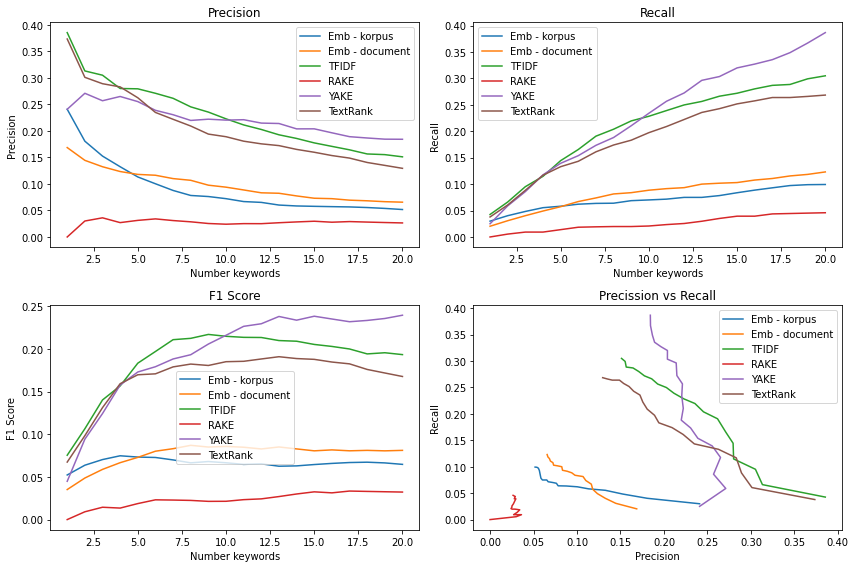

In [15]:
fig = plt.figure(figsize=(12,8))
fig.patch.set_facecolor('white')

scores = (
    ("Precision", precisions),
    ("Recall", recalls),
    ("F1 Score", f_scores),
)
for i, (title, sc) in enumerate(scores):
    plt.subplot(2, 2, i + 1)
    for p, (l, _) in zip(sc, methods):
        plt.plot(range(1, 21), p, label=l)
    plt.legend()
    plt.title(title)
    plt.xlabel("Number keywords")
    plt.ylabel(title)
        
plt.subplot(2, 2, 4)
for p, r, (l, _) in zip(precisions, recalls, methods):
    plt.plot(p, r, label=l)
    plt.legend()
    plt.title("Precission vs Recall")
    plt.xlabel("Precision")
    plt.ylabel("Recall")

plt.tight_layout()

Iz grafov lahko sklepamo, da se na primeru člankov iz revije Prispevki za novejšo zgodovino najbolje obneseta metodi TF-IDF in YAKE!. Sledi TextRank. Podobno se obneseta metodi z vložitvami, najslabše pa se obnese metoda RAKE.